# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_1_raw_data/run_1/app_data/RK.8D1DBFAD.DJWThesis_20220929-20220930/HealthKitSamples_20220929-20220930.csv')

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_29266/2086850739.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_1_raw_data/run_1/app_data/RK.8D1DBFAD.DJWThesis_20220929-20220930/HealthKitSamples_20220929-20220930.csv')


In [6]:
df.Type.unique()

array(['DistanceWalkingRunning', 'HeartRate', 'DailySteps',
       'ActiveEnergyBurned', 'Steps', 'AppleStandTime',
       'HeartRateVariability', 'RestingEnergyBurned', 'StandHourInterval',
       'WalkingSpeed', 'SleepAnalysisInterval', 'HandwashingEvent',
       'EnvironmentalAudioExposure', 'WalkingHeartRateAverage',
       'HeadphoneAudioExposure', 'RestingHeartRate', 'AudioExposureEvent'],
      dtype=object)

# Load Data

Currently the `df_cleaned_no_outliers` dataframe is being processed in the `03_categorical_gap.ipynb` notebook.

# Reduction in Exercise over Semester

In [ ]:
# Run mixed linear model with random slopes and intercepts
# Drop any rows with NaN or inf values first
df_model = df_cleaned_no_outliers.dropna(subset=['passive_sk_device_total_usage_health_and_fitness', 'day'])

# Import statsmodels
import statsmodels.api as sm

# Scale the predictor variable within each subject
df_model['health_fitness_scaled'] = df_model.groupby('PID')['passive_sk_device_total_usage_health_and_fitness'].transform(
    lambda x: (x - x.mean()) / x.std()
)

X = sm.add_constant(df_model['health_fitness_scaled'])
exog_re = df_model['health_fitness_scaled']

# Try different optimization methods and starting values
optimization_methods = ['bfgs', 'lbfgs', 'cg', 'newton']
best_fit = None
best_llf = float('-inf')

for method in optimization_methods:
    try:
        mlm = sm.MixedLM(
            df_model['day'],
            X, 
            groups=df_model['PID'],
            exog_re=exog_re
        )
        
        # Try different starting values
        start_params = None if method != 'newton' else [1.0] * (len(X.columns) + 2)
        
        fit = mlm.fit(method=method, 
                     start_params=start_params,
                     maxiter=1000,
                     xtol=1e-8,
                     ftol=1e-8)
        
        if fit.llf > best_llf:
            best_fit = fit
            best_llf = fit.llf
            
    except:
        continue

if best_fit is not None:
    print(f"Best converged model using method: {method}")
    print(best_fit.summary())
else:
    print("Failed to converge with any method")


/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_33078/1860209510.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['health_fitness_scaled'] = df_model.groupby('PID')['passive_sk_device_total_usage_health_and_fitness'].transform(
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2137: UserWarning: Argument xtol not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/base/optimizer.p

Best converged model using method: newton
                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     day        
No. Observations:     6510        Method:                 REML       
No. Groups:           105         Scale:                  408.3461   
Min. group size:      39          Log-Likelihood:         -28874.5689
Max. group size:      84          Converged:              Yes        
Mean group size:      62.0                                           
---------------------------------------------------------------------
                          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
const                     35.562    0.250 141.992 0.000 35.071 36.053
health_fitness_scaled     -4.643    0.491  -9.457 0.000 -5.606 -3.681
health_fitness_scaled Var 18.357    0.172                            



/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2137: UserWarning: Argument xtol not used by MixedLM.fit
  warnings.warn("Argument %s not used by MixedLM.fit" % x)


# People are lazy on weekends


Average walking/running distance by day of week (mean ± SE):
Monday: 6119.020 ± 336.361
Tuesday: 6776.021 ± 297.620
Wednesday: 6328.284 ± 328.115
Thursday: 6734.659 ± 346.718
Friday: 6304.074 ± 329.417
Saturday: 5255.151 ± 298.485
Sunday: 4644.262 ± 318.805


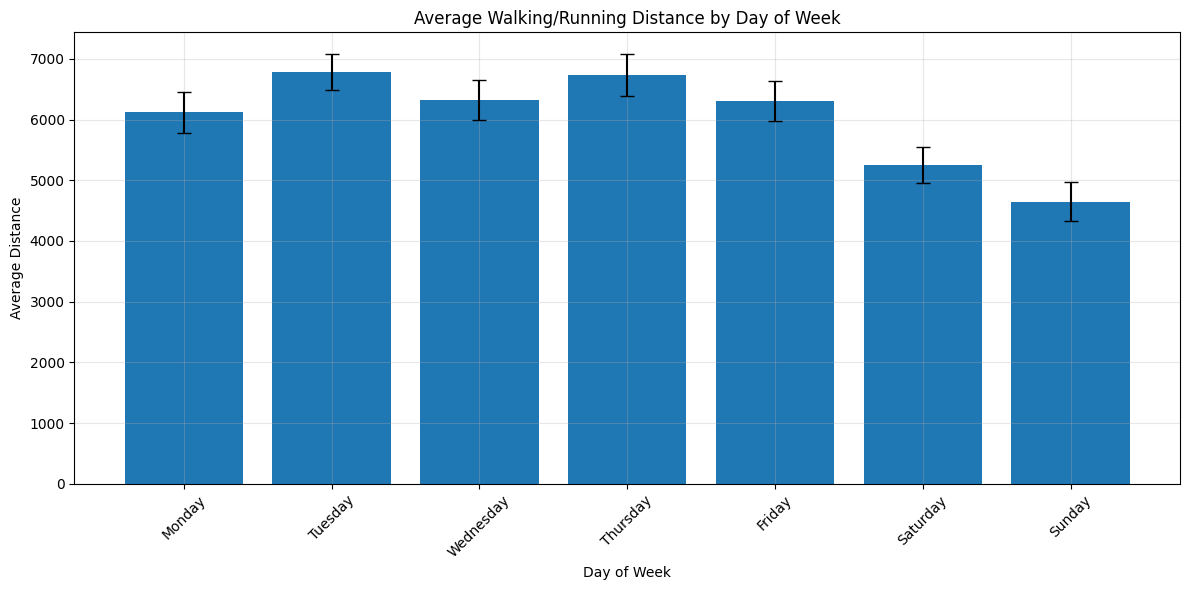

In [ ]:
# Get day of week from trial_date and calculate average distance per day
# Create ordered days starting with Monday
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# First calculate within-subject averages
subject_day_averages = df.groupby(['PID', df['trial_date'].dt.day_name()])['passive_hk_activity_distanceWalkingRunning'].mean().reset_index()

# Then calculate across-subject means and standard errors
day_stats = subject_day_averages.groupby('trial_date')['passive_hk_activity_distanceWalkingRunning'].agg(['mean', 'std']).reindex(days_order)
day_stats['se'] = day_stats['std'] / np.sqrt(df['PID'].nunique())

# Create bar plot with error bars
plt.figure(figsize=(12,6))
plt.bar(day_stats.index, day_stats['mean'])
plt.errorbar(day_stats.index, day_stats['mean'], yerr=day_stats['se'], 
             fmt='none', color='black', capsize=5)

plt.title('Average Walking/Running Distance by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Distance')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Print the averages and standard errors
print("\nAverage walking/running distance by day of week (mean ± SE):")
for day in days_order:
    print(f"{day}: {day_stats.loc[day, 'mean']:.3f} ± {day_stats.loc[day, 'se']:.3f}")

# IBG - Active Energy Correlation Mechanism

**activeEnergyBurned**

Was there a goal to exercise (based on goals and self-report) - is that what drives the reduction in gap?

Take the two individual goals do they include exercise?

Look at individual differences: Survey data on weather health goals are important to them

# The Appeal of the Unknown

Some of the top predictors of affect are correlated with the number of "unknown" places we go in a day...

# CSS goes down over semester after learning period?

# CSS Lowest on Saturday

In [ ]:
# Convert trial_date to datetime if not already
df['trial_date'] = pd.to_datetime(df['trial_date'])

# Extract day of week (0=Monday, 6=Sunday)
df['day_of_week'] = df['trial_date'].dt.dayofweek

# Calculate mean and standard error of css for each day
day_stats = df.groupby('day_of_week')['css'].agg(['mean', 'std', 'count']).reset_index()
day_stats['se'] = day_stats['std'] / np.sqrt(day_stats['count'])

# Create day labels
day_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create the plot
plt.figure(figsize=(10, 6))
plt.errorbar(day_stats['day_of_week'], day_stats['mean'], 
            yerr=day_stats['se'], fmt='o-', capsize=5)

# Customize the plot
plt.xticks(range(7), day_labels, rotation=45)
plt.xlabel('Day of Week')
plt.ylabel('CSS Score')
plt.title('Average CSS Score by Day of Week')
plt.grid(True, alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Get your work done early correlates with better grades

Pairwise complete correlation between mean task motivation time and grades: -0.223, p=0.0220


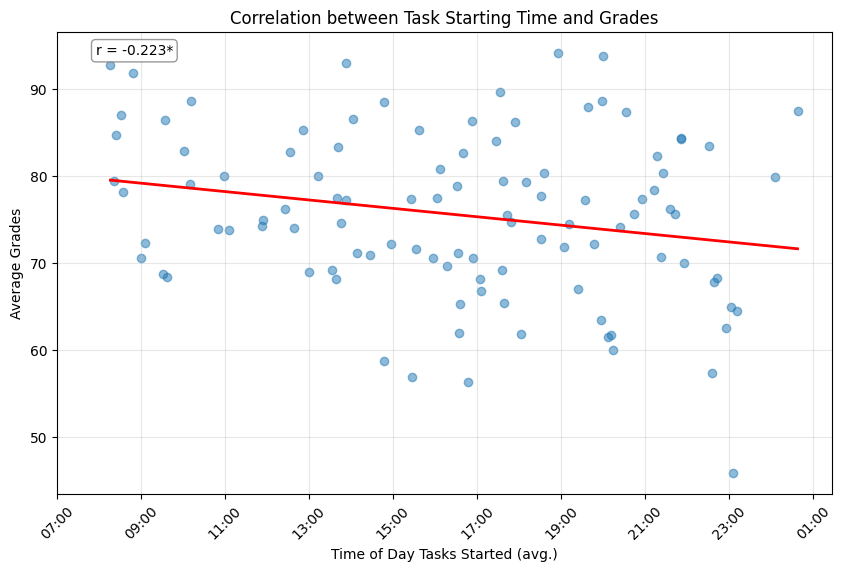

In [ ]:
# These dataframes are in 09_battery_analysis

# Calculate mean task motivation time for each participant
mean_motivation_time = df_daily.groupby('PID')['task_motivation_min_after_5am'].mean()

# Create dataframe with PID and mean motivation time
motivation_df = mean_motivation_time.reset_index()

# Get grades with PID from outcome_df
grades_df = outcome_df[['PID', 'battery_outcome_grades_avg_avg']].copy()

# Merge the dataframes on PID
correlation_df = motivation_df.merge(grades_df, on='PID', how='inner')

# Calculate pairwise complete correlation (dropping any rows with NaN values)
correlation = correlation_df['task_motivation_min_after_5am'].corr(correlation_df['battery_outcome_grades_avg_avg'], method='pearson')

# Calculate significance level with scipy
from scipy import stats
valid_data = correlation_df.dropna()
r_value, p_value = stats.pearsonr(valid_data['task_motivation_min_after_5am'], valid_data['battery_outcome_grades_avg_avg'])

print(f"Pairwise complete correlation between mean task motivation time and grades: {correlation:.3f}, p={p_value:.4f}")

# Visualize with scatter plot, only plotting non-NaN pairs
plt.figure(figsize=(10,6))
plt.scatter(valid_data['task_motivation_min_after_5am'], valid_data['battery_outcome_grades_avg_avg'], alpha=0.5)

# Add regression line
slope, intercept = np.polyfit(valid_data['task_motivation_min_after_5am'], valid_data['battery_outcome_grades_avg_avg'], 1)
x_values = np.array([valid_data['task_motivation_min_after_5am'].min(), valid_data['task_motivation_min_after_5am'].max()])
plt.plot(x_values, slope * x_values + intercept, 'r-', lw=2)

# Add correlation and significance annotation
sig_symbol = ''
if p_value < 0.001:
    sig_symbol = '***'
elif p_value < 0.01:
    sig_symbol = '**'
elif p_value < 0.05:
    sig_symbol = '*'
    
plt.annotate(f'r = {r_value:.3f}{sig_symbol}', 
             xy=(0.05, 0.95), 
             xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Set x-ticks from 7am to 1am (every 2 hours)
# 7am is 120 minutes after 5am, 1am is 1200 minutes after 5am
xticks = np.arange(120, 1200+120, 120)
plt.xticks(xticks)

# Convert minutes after 5am to time strings
def mins_to_time(mins):
    hours = ((mins // 60) + 5) % 24  # Add 5 hours and wrap around 24
    return f'{int(hours):02d}:00'

plt.gca().set_xticklabels([mins_to_time(x) for x in xticks], rotation=45)
plt.xlabel('Time of Day Tasks Started (avg.)')
plt.ylabel('Average Grades')
plt.title('Correlation between Task Starting Time and Grades')
plt.grid(True, alpha=0.3)

# Estimating BMI


Analyzing correlation between battery_outcome_rw_bmi_avg and daily_passive_hk_hr_averageWalking:
Number of participants with both Value Sensitivity and Daily Social Networking Usage (minutes) data: 105
Number of participants after removing NaNs: 93
Correlation: 0.262, p-value: 0.0113


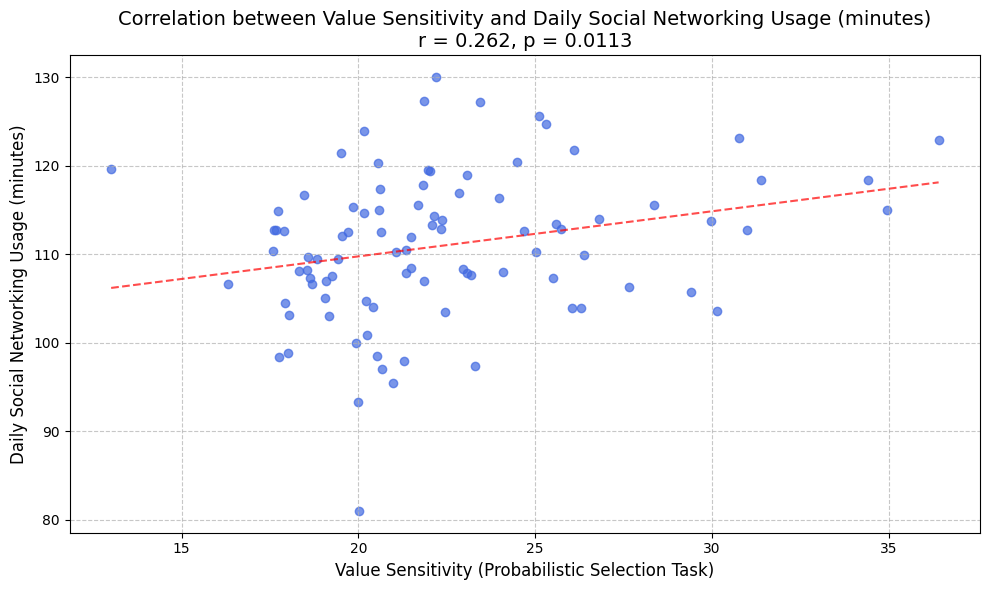

(                                      PID  battery_outcome_rw_bmi_avg  \
 0    2262249f-9158-4ba1-9555-fa961d86e92e                   25.111940   
 2    6e86c427-c679-4acd-aeb4-19ada9022b66                   25.515029   
 3    c62ae7a2-6fe6-4fd5-9b9e-93773b08d8b9                   19.093637   
 4    bf670311-c590-473a-98ab-d719ebf0f2ab                   20.147662   
 5    5e509967-0d3b-4fe1-a275-231ba42473d5                   21.845059   
 ..                                    ...                         ...   
 99   077803ce-0421-40c5-846d-40f0a9ac6a83                   17.716877   
 100  9f0105f6-8198-4bee-8717-7df0d8903e76                   19.244907   
 101  08e76051-ee6e-4872-896f-4ed3857afc0f                   21.349905   
 102  5599c2a7-88a5-4cde-9f2a-41b4bd03d660                   22.093273   
 104  b62d508b-4768-4dc4-9bf3-bc8f59bf2388                   21.077755   
 
      daily_passive_hk_hr_averageWalking  
 0                            125.599673  
 2                      

In [ ]:
def analyze_correlation(
    df_battery, 
    df_daily_means, 
    battery_var, 
    daily_var, 
    battery_var_label=None, 
    daily_var_label=None,
    battery_var_source=None
):
    """
    Analyze correlation between a battery outcome variable and a daily activity variable.
    
    Parameters:
    - df_battery: DataFrame with battery task outcomes
    - df_daily_means: DataFrame with daily activity data
    - battery_var: Column name for the battery variable
    - daily_var: Column name for the daily activity variable
    - battery_var_label: Human-readable label for battery variable (optional)
    - daily_var_label: Human-readable label for daily variable (optional)
    - battery_var_source: Name of the battery task (optional)
    """
    print(f"\nAnalyzing correlation between {battery_var} and {daily_var}:")
    
    # Use provided labels or default to variable names
    battery_var_label = battery_var_label or battery_var
    daily_var_label = daily_var_label or daily_var
    battery_var_source = battery_var_source or "Battery Task"
    
    # Check if both variables exist in our data
    if battery_var in df_battery.columns and daily_var in df_daily_means.columns:
        # Get participant IDs from both dataframes
        battery_pids = df_battery['PID'].values
        daily_pids = df_daily_means['PID'].values
        
        # Find common participants
        common_pids = np.intersect1d(battery_pids, daily_pids)
        print(f"Number of participants with both {battery_var_label} and {daily_var_label} data: {len(common_pids)}")
        
        # Filter data for common participants
        battery_filtered = df_battery[df_battery['PID'].isin(common_pids)]
        daily_filtered = df_daily_means[df_daily_means['PID'].isin(common_pids)]
        
        # Create a merged dataframe with just the variables we need
        merged_data = pd.merge(
            battery_filtered[['PID', battery_var]],
            daily_filtered[['PID', daily_var]],
            on='PID'
        )
        
        # Remove rows with NaN values
        merged_data = merged_data.dropna()
        print(f"Number of participants after removing NaNs: {len(merged_data)}")
        
        # Calculate correlation
        if len(merged_data) > 5:  # Ensure we have enough data points
            corr, p_value = pearsonr(merged_data[battery_var], merged_data[daily_var])
            print(f"Correlation: {corr:.3f}, p-value: {p_value:.4f}")
            
            # Create scatter plot with regression line
            plt.figure(figsize=(10, 6))
            
            # Plot scatter points
            plt.scatter(merged_data[battery_var], merged_data[daily_var], 
                       alpha=0.7, color='royalblue')
            
            # Add regression line
            slope, intercept, r_value, p_value, std_err = linregress(
                merged_data[battery_var], 
                merged_data[daily_var]
            )
            x_vals = np.array([merged_data[battery_var].min(), merged_data[battery_var].max()])
            y_vals = intercept + slope * x_vals
            plt.plot(x_vals, y_vals, 'r--', alpha=0.7)
            
            # Add labels and title
            plt.xlabel(f'{battery_var_label} ({battery_var_source})', fontsize=12)
            plt.ylabel(f'{daily_var_label}', fontsize=12)
            plt.title(f'Correlation between {battery_var_label} and {daily_var_label}\nr = {corr:.3f}, p = {p_value:.4f}', fontsize=14)
            
            # Add grid for better readability
            plt.grid(True, linestyle='--', alpha=0.7)
            
            plt.tight_layout()
            plt.show()
            
            return merged_data, corr, p_value
        else:
            print("Not enough data points to calculate correlation after removing NaNs.")
            return None, None, None
    else:
        print(f"One or both variables not found in the dataframes.")
        return None, None, None

# Example usage:
# Analyze value sensitivity and social networking usage
analyze_correlation(
    df_battery=df_battery,
    df_daily_means=df_daily_means,
    battery_var='battery_outcome_rw_bmi_avg',
    daily_var='daily_passive_hk_hr_averageWalking',
    battery_var_label='Value Sensitivity',
    daily_var_label='Daily Social Networking Usage (minutes)',
    battery_var_source='Probabilistic Selection Task'
)

In [ ]:
# Create a merged dataframe that combines battery data with daily averages
print("Creating merged dataframe with battery data and daily averages...")

# First, check if we have the necessary dataframes
if 'df_battery' not in globals() or 'df_daily_means' not in globals():
    print("Warning: Required dataframes not found. Make sure df_battery and df_daily_means exist.")
else:
    # Create a new merged dataframe by joining on PID
    merged_df_avg = pd.merge(
        df_battery,
        df_daily_means,
        on='PID',
        how='inner',  # Only keep participants who have both battery and daily data
        suffixes=('', '_daily')
    )
    
    # Display information about the merged dataframe
    print(f"Merged dataframe created with {merged_df_avg.shape[0]} participants and {merged_df_avg.shape[1]} variables")
    print(f"Number of participants in original battery data: {df_battery['PID'].nunique()}")
    print(f"Number of participants in daily averages: {df_daily_means['PID'].nunique()}")
    print(f"Number of participants in merged data: {merged_df_avg['PID'].nunique()}")
    
    # Display the first few rows of the merged dataframe
    merged_df_avg.head()


Creating merged dataframe with battery data and daily averages...
Merged dataframe created with 105 participants and 623 variables
Number of participants in original battery data: 180
Number of participants in daily averages: 105
Number of participants in merged data: 105


Analyzing correlations between BMI and daily variables...

Top 20 daily variables correlated with BMI:
                                     daily_variable  correlation  p_value  \
152         passive_hk_activity_restingEnergyBurned        0.545   0.0000   
303                 task_bart_score_model_intercept       -0.297   0.0033   
157                    passive_hk_hr_averageWalking        0.262   0.0113   
360             passive_sk_device_total_usage_music        0.250   0.0139   
181               passive_sk_device_app_usage_music        0.248   0.0149   
294           task_hanoi_movesTime_model_startPoint       -0.237   0.0237   
102                              task_nback_matched       -0.236   0.0206   
154         passive_hk_activity_averageWalkingSpeed       -0.234   0.0231   
351     passive_sk_device_total_usage_entertainment        0.234   0.0218   
166         passive_sk_device_total_unlock_duration        0.229   0.0247   
167               passive_sk_device_app_usage_book

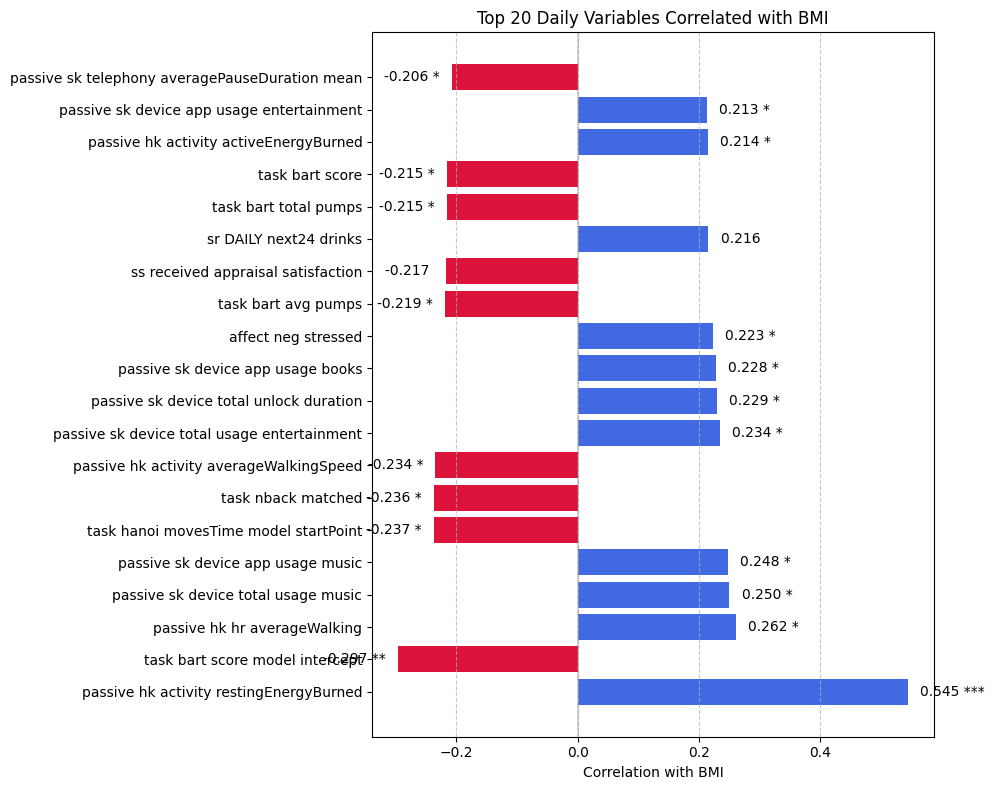

In [ ]:
# Find correlations between BMI and all daily variables
print("Analyzing correlations between BMI and daily variables...")

# Create a list to store correlation results
correlation_results = []

# Get the BMI variable
bmi_var = 'battery_outcome_rw_bmi_avg'

# Find all daily variables in the dataframe, excluding specified patterns
daily_vars = [col for col in merged_df_avg.columns if 
              col.startswith('daily_') and 
              'food_' not in col and
              'interaction_' not in col and
              'residual' not in col and
              not col.endswith('_am')]

# Calculate correlations for each daily variable
for daily_var in daily_vars:
    # Skip if the column has all NaN values
    if merged_df_avg[daily_var].isna().all():
        continue
    
    # Calculate correlation
    valid_data = merged_df_avg[[bmi_var, daily_var]].dropna()
    n_samples = len(valid_data)
    
    # Only calculate if we have enough data points
    if n_samples >= 10:  # Minimum threshold for meaningful correlation
        corr, p_value = pearsonr(valid_data[bmi_var], valid_data[daily_var])
        
        # Store the results
        correlation_results.append({
            'daily_variable': daily_var,
            'correlation': corr,
            'abs_correlation': abs(corr),
            'p_value': p_value,
            'n_samples': n_samples
        })

# Convert to DataFrame and sort by absolute correlation
corr_df = pd.DataFrame(correlation_results)
corr_df = corr_df.sort_values('abs_correlation', ascending=False)

# Display the top 20 correlations
print("\nTop 20 daily variables correlated with BMI:")
top_20 = corr_df.head(20)

# Format the output for better readability
pd.set_option('display.max_colwidth', 100)
formatted_results = top_20.copy()
formatted_results['daily_variable'] = formatted_results['daily_variable'].str.replace('daily_', '')
formatted_results['correlation'] = formatted_results['correlation'].round(3)
formatted_results['p_value'] = formatted_results['p_value'].round(4)
print(formatted_results[['daily_variable', 'correlation', 'p_value', 'n_samples']])

# Create a horizontal bar chart of the top correlations
plt.figure(figsize=(10, 8))
bars = plt.barh(
    y=np.arange(len(top_20)),
    width=top_20['correlation'],
    color=[('royalblue' if c > 0 else 'crimson') for c in top_20['correlation']]
)

# Add labels and formatting
plt.yticks(np.arange(len(top_20)), [v.replace('daily_', '').replace('_', ' ') for v in top_20['daily_variable']])
plt.xlabel('Correlation with BMI')
plt.title('Top 20 Daily Variables Correlated with BMI')
plt.axvline(x=0, color='gray', linestyle='-', alpha=0.3)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add correlation values as text
for i, bar in enumerate(bars):
    corr_value = top_20['correlation'].iloc[i]
    p_value = top_20['p_value'].iloc[i]
    text_color = 'black'
    x_pos = corr_value + (0.02 if corr_value > 0 else -0.02)
    ha = 'left' if corr_value > 0 else 'right'
    
    # Add asterisks for significance
    sig_markers = ''
    if p_value < 0.001:
        sig_markers = '***'
    elif p_value < 0.01:
        sig_markers = '**'
    elif p_value < 0.05:
        sig_markers = '*'
    
    plt.text(x_pos, i, f"{corr_value:.3f} {sig_markers}", va='center', ha=ha, color=text_color)

plt.tight_layout()
plt.show()


# Sleep

Lowest sleep night before exam

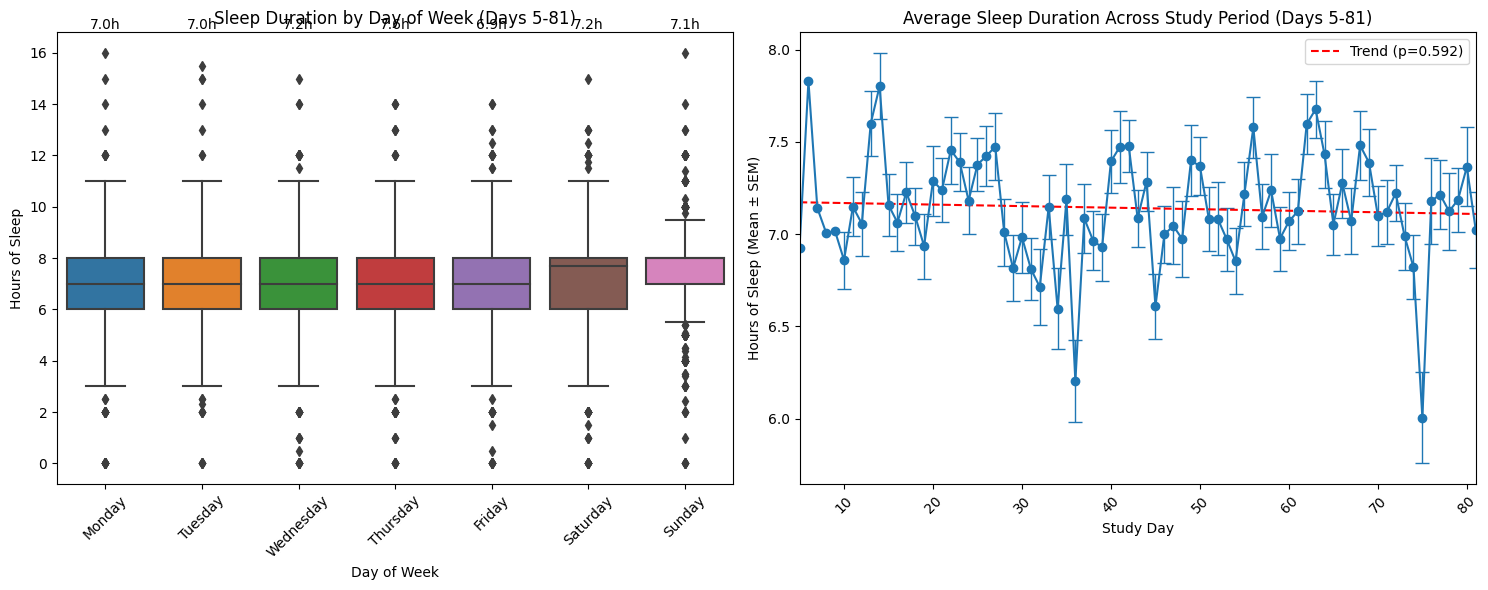


Dates with lowest average sleep:
Day 75: 2023-03-06 - 6.00 hours
Day 36: 2023-04-14 - 6.20 hours


In [ ]:
# Convert trial_date to datetime if it's not already
df_good['trial_date'] = pd.to_datetime(df_good['trial_date'])

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Filter data for days 5-81
df_filtered = df_good[df_good['day'].between(5, 81)]

# Plot 1: Box plot for each day of the week
sns.boxplot(
    data=df_filtered,
    x=df_filtered['trial_date'].dt.day_name(),
    y='sr_DAILY_past24_sleep',
    ax=ax1,
    order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

# Calculate and add mean values as text annotations
daily_means = df_filtered.groupby(df_filtered['trial_date'].dt.day_name())['sr_DAILY_past24_sleep'].mean()
for i, mean in enumerate(daily_means):
    ax1.text(i, ax1.get_ylim()[1], f'{mean:.1f}h', 
             horizontalalignment='center', verticalalignment='bottom')

ax1.set_title('Sleep Duration by Day of Week (Days 5-81)')
ax1.set_xlabel('Day of Week')
ax1.set_ylabel('Hours of Sleep')
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Mean and error bars across study days
daily_sleep = df_filtered.groupby('day')['sr_DAILY_past24_sleep'].agg(['mean', 'std']).reset_index()
daily_sleep['sem'] = daily_sleep['std'] / np.sqrt(df_filtered.groupby('day').size())

ax2.errorbar(
    x=daily_sleep['day'],
    y=daily_sleep['mean'],
    yerr=daily_sleep['sem'],
    fmt='o-',
    capsize=5,
    capthick=1,
    elinewidth=1
)

# Add linear regression line
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(daily_sleep['day'], daily_sleep['mean'])
line = slope * daily_sleep['day'] + intercept
ax2.plot(daily_sleep['day'], line, 'r--', label=f'Trend (p={p_value:.3f})')
ax2.legend()

ax2.set_title('Average Sleep Duration Across Study Period (Days 5-81)')
ax2.set_xlabel('Study Day')
ax2.set_ylabel('Hours of Sleep (Mean ± SEM)')
ax2.tick_params(axis='x', rotation=45)

# Set x-axis limits for second plot
ax2.set_xlim(5, 81)

plt.tight_layout()
plt.show()

# Find and print the two days with lowest average sleep
lowest_sleep_days = daily_sleep.nsmallest(2, 'mean')
dates_of_lowest_sleep = df_filtered[df_filtered['day'].isin(lowest_sleep_days['day'])]['trial_date'].dt.date.unique()
print("\nDates with lowest average sleep:")
for day, date in zip(lowest_sleep_days['day'], dates_of_lowest_sleep):
    print(f"Day {day}: {date} - {lowest_sleep_days[lowest_sleep_days['day']==day]['mean'].values[0]:.2f} hours")

# Other Ideas

---

### Investigations into "intelligence"
- rate 

Talk to hyuna
- what things predict continued healthy choice outside of the moment of regulation
- using BERT with vectors 

### Daily Coach Experiment?

Train model with goal text data - predict which ones will be accomplished and which won't
- predicting unexpected gaps (based on confidence of whether they got it done)

Can we pick out what predicts goal accomplishment? 
- mixed effects model
- look in individual subjects



Grab bag vs. guiding principle?